In [24]:
import pandas as pd

fetal_health = pd.read_csv('fetal_health.csv')

fetal_health['histogram_tendency'] = fetal_health['histogram_tendency'].astype(str)
fetal_health = pd.get_dummies(fetal_health)
fetal_health.fetal_health = fetal_health.fetal_health.astype(int).astype(str) #make outcome categorical



In [25]:
from sklearn.model_selection import train_test_split


fetal_health, fetal_health_test = train_test_split(fetal_health, 
                                    test_size = .2) ## withold our test set

fetal_health_train, fetal_health_validate = train_test_split(fetal_health, 
                                    test_size = .2) 

In [26]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import f1_score

def accuracy_by_class(predicted, actual):
    out_vector = []
    out_vector.append(np.mean(predicted == actual))
    for i in range(1, 4):
        out_vector.append(np.mean(predicted[actual == str(i)] == str(i)))
    out_vector.append(np.mean(out_vector[1:4]))
    out_vector.append(f1_score(y_true = actual, y_pred = predicted, average = "macro"))
    return(out_vector)
    
    
    
def rebalance_classes(input_df):
    class_1 = input_df.loc[input_df.fetal_health == '1']
    class_2 = input_df.loc[input_df.fetal_health == '2']
    class_3 = input_df.loc[input_df.fetal_health == '3']
    
    class_2 = resample(class_2, n_samples = class_1.shape[0])
    class_3 = resample(class_3, n_samples = class_1.shape[0])
    
    output_df = pd.concat([class_1, class_2, class_3], ignore_index = True)
    return(output_df)



In [27]:
from sklearn.preprocessing import StandardScaler

fetal_health_train = rebalance_classes(fetal_health_train)

scale = StandardScaler()

fetal_health_train_scaler = scale.fit(X = fetal_health_train.drop('fetal_health', axis = 1).to_numpy())

fetal_health_train_x = fetal_health_train_scaler.transform(X = fetal_health_train.drop('fetal_health', axis = 1).to_numpy())

fetal_health_validate_x = fetal_health_train_scaler.transform(X = fetal_health_validate.drop('fetal_health', axis = 1).to_numpy())



In [30]:
from sklearn.neighbors import KNeighborsClassifier



k_to_test = range(2, 100)

for i in k_to_test:
    current_knn = KNeighborsClassifier(n_neighbors= i)
    current_knn_fit = current_knn.fit(X = fetal_health_train_x, y = fetal_health_train.fetal_health)
    currrent_preds = current_knn_fit.predict(X = fetal_health_validate_x )
    if i == 2:
        accuracy_mat = np.matrix(accuracy_by_class(currrent_preds, fetal_health_validate.fetal_health))
    else:
        accuracy_mat = np.vstack([accuracy_mat, 
                                  accuracy_by_class(currrent_preds, fetal_health_validate.fetal_health)])

    
    

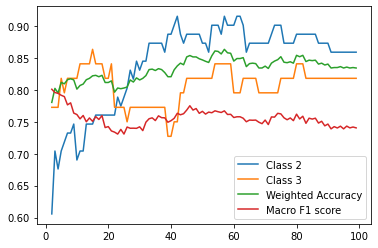

In [31]:
import matplotlib.pyplot as plt

# plt.plot(k_to_test,accuracy_mat[:,0], label = "Overall")
# plt.plot(k_to_test,accuracy_mat[:,1], label = "Class 1")
plt.plot(k_to_test,accuracy_mat[:,2], label = "Class 2")
plt.plot(k_to_test,accuracy_mat[:,3], label = "Class 3")

plt.plot(k_to_test,accuracy_mat[:,4], label = "Weighted Accuracy")
plt.plot(k_to_test,accuracy_mat[:,5], label = "Macro F1 score")

plt.legend()

plt.show()


The plot demonstrates that the highest macro F1 score and weighted accuracy happen when K is around 50

In [33]:

## final model
fetal_health = rebalance_classes(fetal_health)

scale = StandardScaler()

fetal_health_all_scale = scale.fit(X = fetal_health.drop('fetal_health', axis = 1).to_numpy())
fetal_health_x = fetal_health_all_scale.transform(X = fetal_health.drop('fetal_health', axis = 1).to_numpy())

fetal_health_test_x = fetal_health_all_scale.transform(X = fetal_health_test.drop('fetal_health', axis = 1).to_numpy())





knn_10 = KNeighborsClassifier(n_neighbors= 50)

knn_10_fit = knn_10.fit(X = fetal_health_x, y = fetal_health.fetal_health)

final_preds = knn_10_fit.predict(X = fetal_health_test_x)




In [35]:

final_accuracy = accuracy_by_class(final_preds, fetal_health_test.fetal_health)

print("Overall accuracy: {}".format(final_accuracy[0]))
for i in range(1,4):
    print("Accuracy for class {}: {}".format(i, final_accuracy[i]))
    
print("Weighted Accuracy: {}".format(final_accuracy[4]))

print("Macro F1 score: {}".format(final_accuracy[5]))
    

Overall accuracy: 0.8544600938967136
Accuracy for class 1: 0.8414634146341463
Accuracy for class 2: 0.92
Accuracy for class 3: 0.875
Weighted Accuracy: 0.8788211382113822
Macro F1 score: 0.7931038241834911


So, our KNN model is at least more useful than if we had just guessed that everyone were class 1. 

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,fetal_health,histogram_tendency_-1.0,histogram_tendency_0.0,histogram_tendency_1.0
0,132.0,0.006,0.000,0.006,0.003,0.0,0.000,17.0,2.1,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,1,0,1,0
1,133.0,0.003,0.000,0.008,0.003,0.0,0.000,16.0,2.1,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,1,0,1,0
2,134.0,0.003,0.000,0.008,0.003,0.0,0.000,16.0,2.4,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1,0,0,1
3,132.0,0.007,0.000,0.008,0.000,0.0,0.000,16.0,2.4,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,1,0,0,1
4,131.0,0.005,0.072,0.008,0.003,0.0,0.000,28.0,1.4,0.0,...,5.0,0.0,135.0,134.0,137.0,7.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,144.0,0.000,0.001,0.001,0.000,0.0,0.000,83.0,0.3,31.0,...,2.0,0.0,144.0,144.0,145.0,0.0,3,1,0,0
4961,144.0,0.000,0.011,0.000,0.000,0.0,0.000,79.0,0.3,77.0,...,2.0,0.0,145.0,144.0,146.0,1.0,3,0,0,1
4962,138.0,0.000,0.002,0.010,0.012,0.0,0.002,58.0,2.5,0.0,...,8.0,1.0,117.0,103.0,119.0,76.0,3,0,1,0
4963,110.0,0.003,0.002,0.006,0.006,0.0,0.002,68.0,3.1,0.0,...,8.0,0.0,91.0,82.0,95.0,42.0,3,1,0,0


In [18]:
my_vec = [0, 1, 2, 3, 4]

my_vec[1:3]


[1, 2]